In [73]:
import sys 
import os 
import re 
import csv
import time
import codecs

import numpy as np
import pandas as pd

import logging
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Conv1D, BatchNormalization, GRU
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam, RMSprop


from gensim.models import Word2Vec
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

start_time = time.time()
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), test_data=(), interval=1):
        super(Callback, self).__init__()
        
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.X_test, self.y_test = test_data
        self.y_val = self.y_val[:, 1]
        self.y_test = self.y_test[:, 1]
        self.T = 0.5
    
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_val = self.model.predict(self.X_val, verbose=0)[:, 1]
            y_test = self.model.predict(self.X_test, verbose=0)[:, 1]
            y_val[y_val >= self.T] = 1
            y_val[y_val < self.T] = 0
            y_test[y_test >= self.T] = 1
            y_test[y_test < self.T] = 0
            
            val_score = f1_score(self.y_val, y_val)
            test_score = f1_score(self.y_test, y_test)
            print("F1 : Epoch : {} \t Valid Score : {:.4f} \t Test Score : {:.4f}".format(epoch+1, val_score, test_score))

In [76]:
def get_data():
    train = pd.read_csv("../input/avlpp-2/train_ne.csv")
    test = pd.read_csv("../input/avalaraproduct-classification/test_ne_imputed.csv")
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    train = train[['fold_id', 'title', 'description', 'text', 'category', 'source']]
    test = test[['title', 'description', 'text', 'category']]
    train.dropna(inplace=True)
    
    return train, test

In [77]:
train, test = get_data()
target = 'category'

Train Shape : (1199998, 5)
Test Shape :  (92, 5)


In [78]:
train.head()

,fold_id,title,description,text,category
0,1,ziczac black red euro 44,clothing related products b2c shoes shoe laces,ziczac black red euro 44 clothing related prod...,R
1,1,9x9 resista 484938,publishing printing printing services,9x9 resista 484938 publishing printing printin...,S
2,1,halle pant short inseam 013049561d0010001 02,clothing related products b2c general,halle pant short inseam 013049561d0010001 02 c...,R
3,1,harry houser travel expenses meals,security personnel,harry houser travel expenses meals security pe...,S
4,1,tee time 740078609 greens fee composite,admissions green fees privately owned golf course,tee time 740078609 greens fee composite admiss...,R


In [ ]:
K = 6

In [79]:
train[target] = train[target].map({"R": 0, "S": 1})
train['target_S'] = np.nan
train['target_R'] = np.nan
train['target_R'] = 1 - train[target].values
train['target_S'] = train[target].values

train.drop([target], axis=1, inplace=True)

In [80]:
test[target] = test[target].map({"R": 0, "S": 1})
test['target_S'] = np.nan
test['target_R'] = np.nan
test['target_R'] = 1 - test[target].values
test['target_S'] = test[target].values

test.drop([target], axis=1, inplace=True)

In [ ]:
### Splitter

def splitter(data, k=K):
    
    data_v1 = data[data['fold_id'] == k].copy()
    data_v1.reset_index(drop=True, inplace=True)
    
    train_set = data_v1[data_v1['source'] == 'train'].copy()
    valid_set = data_v1[data_v1['source'] == 'valid'].copy()
    train_set.reset_index(drop=True, inplace=True)
    valid_set.reset_index(drop=True, inplace=True)
    
    del data_v1
    gc.collect()
    
#     print(train_set.shape, valid_set.shape)
    
    return train_set, valid_set, train_set[list_classes].values, valid_set[list_classes].values

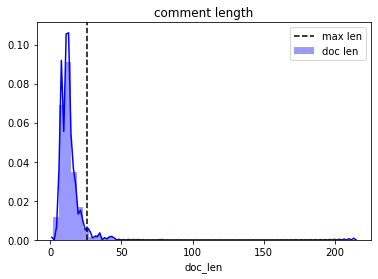

In [81]:
# visualize word length distribution
train['doc_len'] = train['text'].apply(lambda words: len(words.split(" ")))
max_len = np.round(train['doc_len'].mean() + 2*train['doc_len'].std()).astype(int)

sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_len, color='k', linestyle='--', label='max len')
plt.title('comment length')
plt.legend()
plt.show()

In [82]:
max_len

26

In [83]:
embed_size = 100
# embedding_path = "../input/glove840b300dtxt/glove.840B.300d.txt"
max_features = 1_000_000
max_len = 50

BS = 128
N_EPOCHS = 5

In [ ]:
list_classes = ["target_R", "target_S"]
y_test = test[list_classes].values

X_train, X_valid, y_new_train, y_new_valid = splitter(train)
# print(X_train.shape, X_valid.shape, y_new_train.shape, y_new_valid.shape)

## Custom Word2Vec

In [85]:
%%time

col = 'text'

values = train[col].progress_apply(lambda x: x.split()).values.tolist() + test[col].progress_apply(
    lambda x: x.split()).values.tolist()
embedding_index = Word2Vec(values, min_count=5, size=embed_size)
print("Length of Vocabulary : {}".format(len(embedding_index.wv.vocab)))

100%|██████████| 92/92 [00:00<00:00, 61027.36it/s]


Length of Vocabulary : 47157
CPU times: user 3min 59s, sys: 1.75 s, total: 4min 1s
Wall time: 2min 28s


In [86]:
embedding_index["shirt"].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(100,)

In [87]:
raw_text_train = X_train['text'].str.lower()
raw_text_valid = X_valid['text'].str.lower()
raw_text_test = test['text'].str.lower()

In [88]:
%%time

tk = Tokenizer(num_words=max_features, lower=True)
tk.fit_on_texts(raw_text_train.values.tolist() + raw_text_valid.values.tolist() + test['text'].values.tolist())
X_train['seq'] = tk.texts_to_sequences(raw_text_train.values)
X_valid['seq'] = tk.texts_to_sequences(raw_text_valid.values)
test['seq'] = tk.texts_to_sequences(raw_text_test.values)

X_train = pad_sequences(X_train.seq, maxlen=max_len)
X_valid = pad_sequences(X_valid.seq, maxlen=max_len)
test = pad_sequences(test.seq, maxlen=max_len)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


CPU times: user 6.56 s, sys: 32.4 ms, total: 6.59 s
Wall time: 6.61 s


## Word2Vec

In [89]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
cnt = 0
for word, i in tqdm_notebook(word_index.items()):
    if i>= nb_words:
        continue
    try:
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            cnt += 1
    except KeyError:
        continue
cov = (cnt / nb_words)*100
print("Number of words : {}".format(nb_words))
print("Coverage : {:.2f}".format(cov))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.



Number of words : 156328
Coverage : 21.61


In [90]:
file_path = "model.hdf5"
check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

## Modelling Utils

## CNN

In [92]:
def build_model_cnn(embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0):
    
    inp = Input(shape=(max_len, ))

    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    model = load_model(file_path)
    
    return model

## BiLSTM+CNN

In [97]:
def build_model_bilstm_cnn(embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0):
    
    inp = Input(shape=(max_len, ))
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(dr)(x)
    
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x = Conv1D(64, kernel_size=2, padding="valid", kernel_initializer="he_uniform")(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    
    x = Dense(2, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    model = load_model(file_path)
    
    return model

In [93]:
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2

model = build_model_cnn(embedding_matrix, lr, lr_d, units, dr)

Train on 107955 samples, validate on 11995 samples
Epoch 1/5
107955/107955 [==============================] - 5s 46us/step - loss: 0.1591 - accuracy: 0.9358 - val_loss: 0.1225 - val_accuracy: 0.9489
F1 : Epoch : 1 	 Valid Score : 0.9506 	 Test Score : 0.8504

Epoch 00001: val_loss improved from inf to 0.12249, saving model to model.hdf5
Epoch 2/5
107955/107955 [==============================] - 5s 44us/step - loss: 0.1214 - accuracy: 0.9506 - val_loss: 0.1185 - val_accuracy: 0.9517
F1 : Epoch : 2 	 Valid Score : 0.9537 	 Test Score : 0.8462

Epoch 00002: val_loss improved from 0.12249 to 0.11848, saving model to model.hdf5
Epoch 3/5
107955/107955 [==============================] - 5s 42us/step - loss: 0.1117 - accuracy: 0.9546 - val_loss: 0.1111 - val_accuracy: 0.9540
F1 : Epoch : 3 	 Valid Score : 0.9552 	 Test Score : 0.8254

Epoch 00003: val_loss improved from 0.11848 to 0.11110, saving model to model.hdf5
Epoch 4/5
107955/107955 [==============================] - 5s 45us/step - los

In [101]:
model_1 = build_model_bilstm_cnn(embedding_matrix, lr, lr_d, units, dr)

Train on 107955 samples, validate on 11995 samples
Epoch 1/1
107955/107955 [==============================] - 201s 2ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0026 - val_accuracy: 0.9994
F1 : Epoch : 1 	 Valid Score : 0.9994 	 Test Score : 0.8932

Epoch 00001: val_loss did not improve from 0.00223


In [94]:
sub = pd.DataFrame()
sub['word2vec_cust_cnn'] = np.nan
preds = model.predict(test, batch_size=1024, verbose=1)
sub['word2vec_cust_cnn'] = preds[:, 1]
preds = model_1.predict(test, batch_size=1024, verbose=1)
sub['word2vec_cust_lstm'] = preds[:, 1]

In [102]:
print(sub.shape)
sub.head()

92/92 [==============================] - 0s 2ms/step
(92, 2)


,word2vec_cust_cnn,word2vec_cust_lstm
0,0.722099,3.601626e-07
1,0.983842,9.919144e-01
2,0.999993,9.999949e-01
3,0.999998,1.000000e+00
4,0.590205,3.338496e-07


In [103]:
sub.to_csv("custom_w2v.csv", index=False)

## Custom W2V Embedding : 

Coverage : 21.61 (Well this is higher than the coverage of 17% got by pre-trained embeddings).

Best Test - F1 : **0.9245** (Our hypothesis that a custom trained embedding might work better is proved :)  )

PS : **baselined by CNN becuase it veryyyy fast**

# Conclusion

We proved the hypothesis that as this is a very domain-specific task it would be better to train custom embeddings as we have more than enough data to get the contextual meanings and we got a jump to **0.9245** almost equalling our best BOW model.